In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numpy import array

from sklearn.metrics import classification_report, confusion_matrix
import sklearn.model_selection as model_selection

from imutils import paths
import shutil

import os
import time
import random

def train_model(model_to_fit: tf.python.keras.engine.training.Model,
                epochs: int,
                batch: int,
                train_generator: tf.keras.preprocessing.image.Iterator,
                valid_generator: tf.keras.preprocessing.image.Iterator,
                callbacks: list = None):
    
    step_size_train = train_generator.n//train_generator.batch_size
    step_size_valid = valid_generator.n//valid_generator.batch_size

    t = time.process_time()
    
    trained_model_history = model_to_fit.fit(x=train_generator,
                                            steps_per_epoch=step_size_train,
                                            validation_data=valid_generator,
                                            validation_steps=step_size_valid,
                                            epochs=epochs)
    
    elapsed_time = time.process_time() - t
    
    print(f"\n\n ********* Training time: {elapsed_time} s.")
    return trained_model_history

def graph_loss_accuracy(h_model,
                        epochs: int,
                        subtitle: str = ""):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0,epochs),h_model.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,epochs),h_model.history["val_accuracy"],label="val_acc")
    plt.title("Training and Validation Accuracy" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(np.arange(0,epochs),h_model.history["loss"],label="train_loss") 
    plt.plot(np.arange(0,epochs),h_model.history["val_loss"],label="val_loss")
    plt.title("Training and Validation Loss" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Helper functions for reporting

def print_dataset_prediction_report(predictions,
                                    dataset_generator: tf.keras.preprocessing.image.Iterator,
                                    human_readable_labels: list,
                                    dataset_title: str):
    print(f"\n\n ****** {dataset_title} Dataset Prediction Report ******")
    
    # For classification_report the one_hot_encoding test labels are needed,
    #  these are passed in the validation_tuple[1] and test_tuple[1]
    print(f"\n\nClassification Report - {dataset_title}:")
    print(classification_report(dataset_generator.labels, 
                                predictions.argmax(axis=1),
                                target_names=human_readable_labels))

    print(f"\n\nConfusion Matrix: - {dataset_title}:")
    print(confusion_matrix(dataset_generator.labels,
                            predictions.argmax(axis=1)))
    
    print("\n")

def get_model_size(model: tf.python.keras.engine.training.Model) -> int:
    """
        To get the model size, let's write the model to disk, measure it, and
        remove it afterwards.
    """
    model_filename = f"{model.name}.h5"
    
    model.save(model_filename)
    
    # Transform to MB
    size = os.path.getsize(model_filename) / 1024 / 1024
    
    os.remove(model_filename)

    return size

def print_optimizer_summary(model: tf.python.keras.engine.training.Model):
    optimizer_config = model.optimizer.get_config()
    
    print(f"Optimizer Info - {optimizer_config['name']}")

    for key in optimizer_config.keys():
        print(f"\t{key}: {optimizer_config[key]}")

def evaluate_model(model_to_fit: tf.python.keras.engine.training.Model,
                   train_generator: tf.keras.preprocessing.image.Iterator,
                   validation_generator: tf.keras.preprocessing.image.Iterator,
                   test_generator: tf.keras.preprocessing.image.Iterator,                  
                   epochs: int,
                   batch: int,
                   labels: list,
                   callbacks: list = None,
                   title: str = ""):
    
    title = "" if not title else f"{title} - "
    graph_subtitle = f"{title}Epochs: {epochs} Batch: {batch}"

    trained_model_history = train_model(model_to_fit,
                            epochs,
                            batch,
                            train_generator,
                            validation_generator,
                            callbacks=callbacks)
    
    graph_loss_accuracy(trained_model_history,
                        epochs=epochs,
                        subtitle=graph_subtitle)
    
    print("\n\n ************* Model Information *************\n")
    
    model_to_fit.summary()
    
    print(f"Training Dataset Size: {train_generator.n}")
    print(f"Validation Dataset Size: {validation_generator.n}")
    print(f"Test Dataset Size: {test_generator.n}")
    print(f"Batch size: {batch}")
    print(f"Epochs: {epochs}")
    print(f"Input Image Size: {model_to_fit.layers[0].input_shape}")
    print(f"Model size: {get_model_size(model_to_fit)} MB")
    print_optimizer_summary(model_to_fit)
    
    # --------- VALIDATION Predictions -----------

    # The generator must be reset before we use it for predictions because we
    #  already consumed the iterator during the training process
    validation_generator.reset()

    val_model_predictions = model_to_fit.predict(validation_generator,
                                                    batch_size=batch,
                                                    #steps=STEP_SIZE_VALID
                                                    )
    
    print_dataset_prediction_report(val_model_predictions,
                                    validation_generator,
                                    labels,
                                    "Validation")


    # --------- TEST Predictions -----------

    # Use the test_tuple for predictions instead of the validation
    #  The test images are in the first position of the test_tuple
    test_model_predictions = model_to_fit.predict(test_generator,
                                                batch_size=batch)
    
    print_dataset_prediction_report(test_model_predictions,
                                    test_generator,
                                    labels,
                                    "Test")
    



    # Common configurations

BASE_DATA_FOLDER = "C:/Users/Charlie/Desktop/CUDA/datasets/covid19/"
SEED = 2020
HUMAN_READABLE_LABELS = ["Negative", "Positive"]

def get_train_val_test_data_aug_gen(preprocessing_function,
                                    target_size: tuple,
                                    batch_size: int) -> tuple:
    # Given that we have few images, we'll do better with some Data Augmentation
    train_data_augmentation = ImageDataGenerator(
            rescale=1./255, # Normalize the data to be 0-1
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            
            preprocessing_function=preprocessing_function)

    test_augmentation = ImageDataGenerator(rescale=1./255)

    train_generator = train_data_augmentation.flow_from_directory(
        directory=BASE_DATA_FOLDER + "train/",
        target_size=target_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        seed=SEED,
        #save_to_dir="/content/drive/My Drive/Datasets/Covid19/augmented",
        #save_prefix="aug_"
    )

    valid_generator = test_augmentation.flow_from_directory(
        directory=BASE_DATA_FOLDER + "valid/",
        target_size=target_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
        seed=SEED
    )

    test_generator = test_augmentation.flow_from_directory(
        directory=BASE_DATA_FOLDER + "test/",
        target_size=target_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )

    return train_generator, valid_generator, test_generator

In [0]:
def run_vgg16_training():
    vgg16_batch = 32

    train_generator, valid_generator, test_generator = get_train_val_test_data_aug_gen(
        tf.keras.applications.vgg16.preprocess_input,
        (224, 224),
        vgg16_batch)

    base_model = tf.keras.applications.vgg16.VGG16(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )

    # Freeze the weights on the feature extractor so as to keep them!
    base_model.trainable = False

    # Add an FC and Classifier layers

    vgg16_model = tf.keras.models.Sequential([
                    base_model,

                    tf.keras.layers.GlobalAveragePooling2D(),

                    tf.keras.layers.Dense(512, activation='relu'),

                    # Dropout
                    tf.keras.layers.Dropout(0.5),

                    #Output   
                    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
                ], name = "Vgg16-Covid19")

    # Add an optimizer

    vgg16_model.compile(optimizer="adam",
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    evaluate_model(vgg16_model,
                    train_generator,
                    valid_generator,
                    test_generator,                  
                    epochs=2,
                    batch=vgg16_batch,
                    labels=HUMAN_READABLE_LABELS,
                    callbacks = None,
                    title = "Vgg16")

In [3]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]

## GPU

Found 400 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/2
12/12 [==============================] - 18s 1s/step - loss: 0.6597 - accuracy: 0.6332 - val_loss: 0.2912 - val_accuracy: 0.9688
Epoch 2/2
12/12 [==============================] - 15s 1s/step - loss: 0.3291 - accuracy: 0.9010 - val_loss: 0.1814 - val_accuracy: 1.0000


 ********* Training time: 58.875 s.


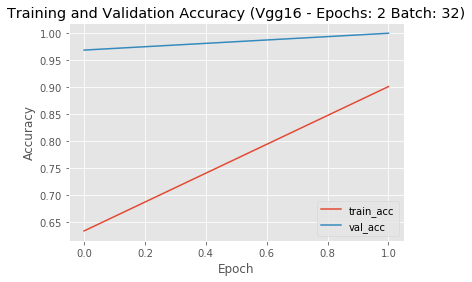

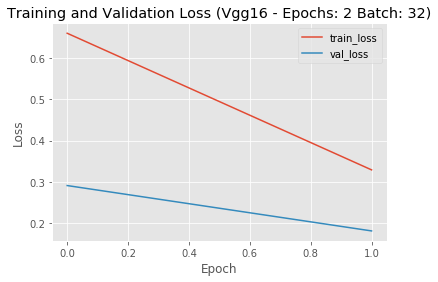



 ************* Model Information *************

Model: "Vgg16-Covid19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________
Training Dataset Size: 400
Validation Dataset Size:

In [7]:
with tf.device("/device:GPU:0"):
    run_vgg16_training()

## CPU

Found 400 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/2
12/12 [==============================] - 65s 5s/step - loss: 0.6467 - accuracy: 0.6005 - val_loss: 0.4727 - val_accuracy: 0.8438
Epoch 2/2
12/12 [==============================] - 68s 6s/step - loss: 0.3580 - accuracy: 0.8587 - val_loss: 0.2256 - val_accuracy: 0.9688


 ********* Training time: 881.453125 s.


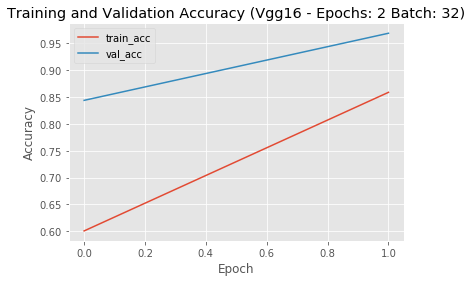

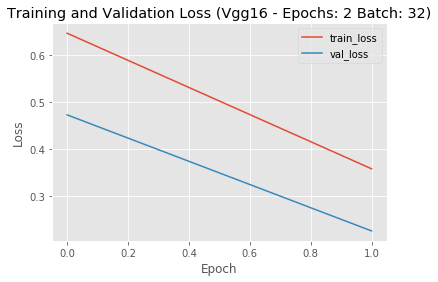



 ************* Model Information *************

Model: "Vgg16-Covid19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________
Training Dataset Size: 400
Validation Dataset Size:

In [6]:
with tf.device("/device:CPU:0"):
    run_vgg16_training()